In [1]:
%load_ext autoreload
%autoreload 2

import math
import pandas as pd
import seaborn as sns
import warnings
%matplotlib inline
pd.set_option('display.max_columns', 500)
pd.set_option('display.max_rows', 1000)
import numpy as np
import pandas as pd
import matplotlib.transforms as transforms


from matplotlib import pyplot as plt
import statsmodels.formula.api as smf
import datetime
import statsmodels

# Local Modules
import sys
import os.path
sys.path.insert(0, os.path.abspath('/scratch/horta/coronawiki/'))
from helpers.load import load_interventions, load_aggregated, load_topics
from helpers.vars import codes, helper_langs, interventions_helper, topics, codes
from helpers.plot import set_size, plot_dates, plot_interventions
from helpers.topics import order_topics, colors_z, get_df_pageviews_topics
from helpers.diffs_n_diffs import get_standard_error_sum
from dateutil.relativedelta import relativedelta

In [2]:
# Latex Configuration
import matplotlib.font_manager as font_manager
from matplotlib.lines import Line2D
import matplotlib.ticker as mtick
import matplotlib.pyplot as plt
import matplotlib as mpl
import seaborn as sns
import os
# fontpath = os.path.expanduser('~/LinLibertine_DRah.ttf')
# prop = font_manager.FontProperties(fname=fontpath)

params = {
    "axes.titlesize" : 14,
    'axes.labelsize': 12,
    'font.size': 12,
    'legend.fontsize': 12,
    'xtick.labelsize': 13,
    'ytick.labelsize': 13,
#     'font.family': 'Linux Libertine Display',
    'text.usetex': False
}

mpl.rcParams.update(params)

In [3]:
interventions = load_interventions("../data/interventions.csv")
topics_df, topics = load_topics('../data/topics_linked.csv.xz')
agg = load_aggregated("../data/aggregated_timeseries.json.gz")
codes_order = ["sr", "it", "fr", "en", "nl", "ko", "de", "fi", "ja", "no", "sv", "da"]
time_int = 35

In [4]:
topics_df.head()

,index,Geography.Regions.Asia.Central Asia,Geography.Regions.Europe.Eastern Europe,History and Society.Military and warfare,Culture.Media.Television,History and Society.Education,Culture.Media.Books,Geography.Regions.Africa.Africa*,Culture.Visual arts.Architecture,Culture.Biography.Women,Geography.Regions.Americas.North America,STEM.STEM*,Culture.Performing arts,Culture.Literature,History and Society.Politics and government,Geography.Regions.Africa.Northern Africa,STEM.Earth and environment,Geography.Regions.Africa.Central Africa,STEM.Medicine & Health,STEM.Libraries & Information,Geography.Regions.Europe.Europe*,Geography.Regions.Europe.Western Europe,Culture.Media.Radio,STEM.Space,Culture.Visual arts.Comics and Anime,STEM.Technology,Culture.Internet culture,Culture.Media.Software,Geography.Regions.Asia.East Asia,Geography.Regions.Europe.Southern Europe,STEM.Biology,Culture.Food and drink,History and Society.Business and economics,Culture.Visual arts.Fashion,Geography.Regions.Americas.Central America,Geography.Geographical,Geography.Regions.Oceania,STEM.Physics,Culture.Media.Films,Geography.Regions.Asia.South Asia,History and Society.Transportation,History and Society.History,Geography.Regions.Africa.Western Africa,Culture.Media.Media*,Geography.Regions.Americas.South America,Culture.Linguistics,STEM.Computing,Culture.Biography.Biography*,Culture.Philosophy and religion,Culture.Sports,Geography.Regions.Africa.Southern Africa,Culture.Visual arts.Visual arts*,Geography.Regions.Africa.Eastern Africa,History and Society.Society,STEM.Engineering,STEM.Mathematics,Geography.Regions.Asia.West Asia,STEM.Chemistry,Geography.Regions.Europe.Northern Europe,Culture.Media.Video games,Geography.Regions.Asia.Southeast Asia,Culture.Media.Entertainment,Culture.Media.Music,Geography.Regions.Asia.Asia*,Geography.Regions.Asia.North Asia,qid
0,Rosmalen,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,True,True,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,Q2001490
1,Commelinales,False,False,False,False,False,False,False,False,False,False,True,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,True,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,Q290349
2,Transport_in_Honduras,False,False,False,False,False,False,False,False,False,False,True,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,True,False,False,False,False,False,True,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,Q1130638
3,QuakeC,False,False,False,False,False,False,False,False,False,False,True,False,False,False,False,False,False,False,False,False,False,False,False,False,True,False,True,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,True,False,False,True,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,Q2122062
4,Food_writing,False,False,False,False,False,False,False,False,False,False,False,False,True,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,True,False,False,False,False,False,False,False,False,False,False,False,True,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,Q5465542


In [5]:
topics

['Culture.Biography.Biography*',
 'Culture.Biography.Women',
 'Culture.Food and drink',
 'Culture.Internet culture',
 'Culture.Linguistics',
 'Culture.Literature',
 'Culture.Media.Books',
 'Culture.Media.Entertainment',
 'Culture.Media.Films',
 'Culture.Media.Media*',
 'Culture.Media.Music',
 'Culture.Media.Radio',
 'Culture.Media.Software',
 'Culture.Media.Television',
 'Culture.Media.Video games',
 'Culture.Performing arts',
 'Culture.Philosophy and religion',
 'Culture.Sports',
 'Culture.Visual arts.Architecture',
 'Culture.Visual arts.Comics and Anime',
 'Culture.Visual arts.Fashion',
 'Culture.Visual arts.Visual arts*',
 'Geography.Geographical',
 'Geography.Regions.Africa.Africa*',
 'Geography.Regions.Africa.Central Africa',
 'Geography.Regions.Africa.Eastern Africa',
 'Geography.Regions.Africa.Northern Africa',
 'Geography.Regions.Africa.Southern Africa',
 'Geography.Regions.Africa.Western Africa',
 'Geography.Regions.Americas.Central America',
 'Geography.Regions.Americas.North

In [6]:
interventions

{'fr': {'1st case': Timestamp('2020-01-24 00:00:00'),
  '1st death': Timestamp('2020-02-14 00:00:00'),
  'School closure': Timestamp('2020-03-14 00:00:00'),
  'Public events banned': Timestamp('2020-03-13 00:00:00'),
  'Lockdown': Timestamp('2020-03-17 00:00:00'),
  'Mobility': Timestamp('2020-03-16 00:00:00'),
  'Normalcy': Timestamp('2020-07-02 00:00:00')},
 'da': {'1st case': Timestamp('2020-02-27 00:00:00'),
  '1st death': Timestamp('2020-03-12 00:00:00'),
  'School closure': Timestamp('2020-03-13 00:00:00'),
  'Public events banned': Timestamp('2020-03-12 00:00:00'),
  'Lockdown': Timestamp('2020-03-18 00:00:00'),
  'Mobility': Timestamp('2020-03-11 00:00:00'),
  'Normalcy': Timestamp('2020-06-05 00:00:00')},
 'de': {'1st case': Timestamp('2020-01-27 00:00:00'),
  '1st death': Timestamp('2020-03-09 00:00:00'),
  'School closure': Timestamp('2020-03-14 00:00:00'),
  'Public events banned': Timestamp('2020-03-22 00:00:00'),
  'Lockdown': Timestamp('2020-03-22 00:00:00'),
  'Mobility

In [7]:
df = pd.DataFrame.from_dict(agg)
df.head()

,ja.m,it,da.m,tr,no.m,en,sr,tr.m,en.m,no,sv,nl.m,nl,da,de,fr.m,ca.m,de.m,ko.m,fi.m,sr.m,ja,fr,fi,ca,it.m,sv.m,ko
len,1197788,1594039,256451,346007,516838,6047509,632128,345790,6045654,531478,3735720,1621578,2003807,258063,2415136,2188967,610575,2407385,489181,480638,396063,1197856,2195949,481854,642031,1588312,1959446,490314
sum,2018-01-01 22328288 2018-01-02 22278953 ...,2018-01-01 3338750 2018-01-02 5428428 ...,2018-01-01 765123 2018-01-02 443384 2018...,2018-01-01 407629 2018-01-02 426791 20...,2018-01-01 715031 2018-01-02 536506 20...,2018-01-01 86763830 2018-01-02 11224534...,2018-01-01 192409 2018-01-02 253653 2018...,2018-01-01 493684 2018-01-02 483443 20...,2018-01-01 135822131 2018-01-02 12708735...,2018-01-01 224417 2018-01-02 374771 20...,2018-01-01 0 2018-01-02 0 20...,2018-01-01 3331046 2018-01-02 2494738 20...,2018-01-01 1199379 2018-01-02 1926749 20...,2018-01-01 206514 2018-01-02 322681 2018...,2018-01-01 9287425 2018-01-02 14474378 ...,2018-01-01 13167585 2018-01-02 12184735 ...,2018-01-01 169499 2018-01-02 149404 2018...,2018-01-01 20345709 2018-01-02 15585298 ...,2018-01-01 1484496 2018-01-02 1248031 20...,2018-01-01 1319053 2018-01-02 1094280 20...,2018-01-01 451383 2018-01-02 462824 20...,2018-01-01 7828155 2018-01-02 8759385 ...,2018-01-01 6441009 2018-01-02 9079323 ...,2018-01-01 523135 2018-01-02 648344 20...,2018-01-01 111910 2018-01-02 198405 20...,2018-01-01 12856884 2018-01-02 12887390 ...,2018-01-01 2383474 2018-01-02 1873096 20...,2018-01-01 819174 2018-01-02 959239 20...
covid,"{'len': 30, 'sum': [55, 55, 51, 46, 70, 77, 73...","{'len': 33, 'sum': [50, 103, 130, 112, 119, 75...","{'len': 4, 'sum': [0, 2, 1, 0, 0, 2, 0, 1, 5, ...","{'len': 64, 'sum': [1, 3, 6, 1, 0, 4, 1, 13, 6...","{'len': 10, 'sum': [7, 5, 2, 2, 2, 0, 3, 2, 7,...","{'len': 306, 'sum': [575, 1081, 1265, 1167, 10...","{'len': 9, 'sum': [6, 13, 11, 6, 13, 6, 11, 9,...","{'len': 64, 'sum': [3, 2, 2, 9, 2, 2, 1, 4, 6,...","{'len': 306, 'sum': [911, 1006, 919, 1026, 978...","{'len': 10, 'sum': [2, 4, 3, 1, 4, 0, 1, 5, 5,...","{'len': 8, 'sum': [0, 0, 0, 0, 0, 0, 0, 0, 0, ...","{'len': 32, 'sum': [19, 18, 16, 14, 15, 18, 10...","{'len': 32, 'sum': [12, 20, 17, 15, 11, 14, 16...","{'len': 4, 'sum': [1, 1, 4, 0, 0, 4, 1, 3, 1, ...","{'len': 77, 'sum': [160, 209, 219, 216, 334, 1...","{'len': 16, 'sum': [116, 105, 98, 104, 114, 10...","{'len': 49, 'sum': [3, 2, 4, 1, 10, 1, 3, 5, 5...","{'len': 77, 'sum': [233, 189, 142, 226, 220, 2...","{'len': 113, 'sum': [6, 5, 8, 8, 10, 2, 7, 7, ...","{'len': 9, 'sum': [0, 0, 8, 0, 0, 2, 0, 3, 1, ...","{'len': 9, 'sum': [11, 20, 15, 30, 33, 17, 31,...","{'len': 30, 'sum': [26, 42, 53, 114, 134, 54, ...","{'len': 16, 'sum': [62, 91, 109, 107, 113, 81,...","{'len': 9, 'sum': [2, 2, 2, 3, 0, 3, 2, 0, 2, ...","{'len': 49, 'sum': [6, 6, 9, 10, 4, 7, 15, 13,...","{'len': 33, 'sum': [139, 187, 162, 180, 127, 1...","{'len': 8, 'sum': [19, 12, 13, 14, 11, 15, 12,...","{'len': 113, 'sum': [3, 20, 20, 16, 20, 8, 1, ..."
topics,{'Culture.Biography.Biography*': {'len': 14904...,{'Culture.Biography.Biography*': {'len': 29427...,{'Culture.Biography.Biography*': {'len': 57720...,{'Culture.Biography.Biography*': {'len': 70443...,{'Culture.Biography.Biography*': {'len': 11603...,{'Culture.Biography.Biography*': {'len': 14038...,{'Culture.Biography.Biography*': {'len': 37718...,{'Culture.Biography.Biography*': {'len': 70434...,{'Culture.Biography.Biography*': {'len': 14038...,{'Culture.Biography.Biography*': {'len': 11804...,{'Culture.Biography.Biography*': {'len': 14706...,{'Culture.Biography.Biography*': {'len': 15284...,{'Culture.Biography.Biography*': {'len': 15294...,{'Culture.Biography.Biography*': {'len': 58323...,{'Culture.Biography.Biography*': {'len': 36668...,{'Culture.Biography.Biography*': {'len': 38254...,{'Culture.Biography.Biography*': {'len': 99190...,{'Culture.Biography.Biography*': {'len': 36663...,{'Culture.Biography.Biography*': {'len': 75406...,{'Culture.Biography.Biography*': {'len': 10422...,{'Cu

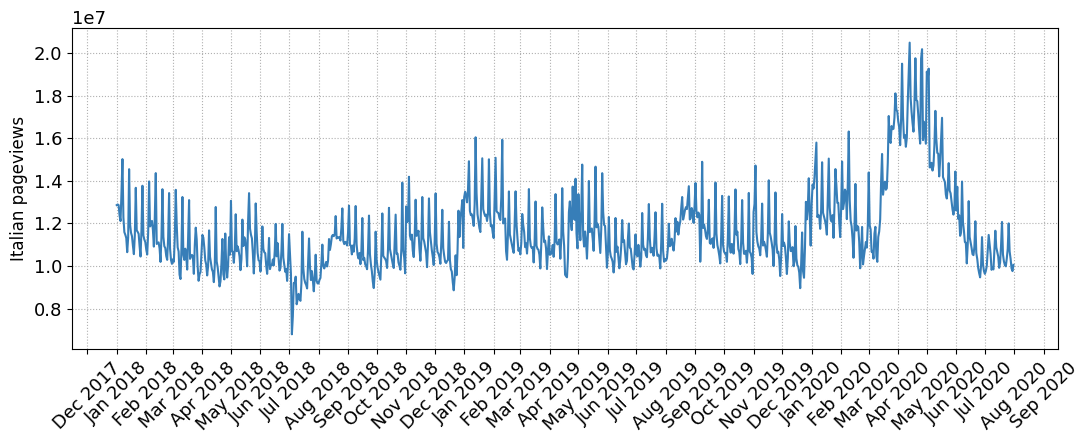

In [8]:
import matplotlib.dates as mdates
italy = agg['it.m']['sum']
# italy = italy[(italy.index.year == 2020) & (italy.index.month <= 12) & (italy.index.month >= 1)]
fig = plt.figure(constrained_layout=False, figsize=(28,10))
gs = fig.add_gridspec(2, 2, hspace=0.4)
ax = fig.add_subplot(gs[0, 0])

ax.plot(italy.index , italy.values, color="#377eb8", zorder=9)

ax.xaxis.set_major_locator(mdates.MonthLocator())
ax.xaxis.set_major_formatter(mdates.DateFormatter('%b %Y'))
plt.setp(ax.get_xticklabels(), rotation=45)
    
ax.set_ylabel("Italian pageviews")

ax.grid(ls=":")

In [9]:
italy

2018-01-01    12856884
2018-01-02    12887390
2018-01-03    12859488
2018-01-04    12359845
2018-01-05    12107559
2018-01-06    13468562
2018-01-07    15015197
2018-01-08    12283946
2018-01-09    11589831
2018-01-10    11465974
2018-01-11    11315575
2018-01-12    10647536
2018-01-13    11338054
2018-01-14    14542868
2018-01-15    11956638
2018-01-16    11558445
2018-01-17    11396513
2018-01-18    10949658
2018-01-19    10555608
2018-01-20    11435495
2018-01-21    13669381
2018-01-22    11673044
2018-01-23    11600203
2018-01-24    11508432
2018-01-25    10933388
2018-01-26    10442157
2018-01-27    11717425
2018-01-28    13766528
2018-01-29    11431941
2018-01-30    11239733
2018-01-31    11124075
2018-02-01    10770777
2018-02-02    10538125
2018-02-03    11520662
2018-02-04    13967880
2018-02-05    11854674
2018-02-06    11954417
2018-02-07    12117301
2018-02-08    11689629
2018-02-09    10908800
2018-02-10    12324508
2018-02-11    14358685
2018-02-12    11033447
2018-02-13 

Dominant frequencies in the dataset and the amplitude is their power:

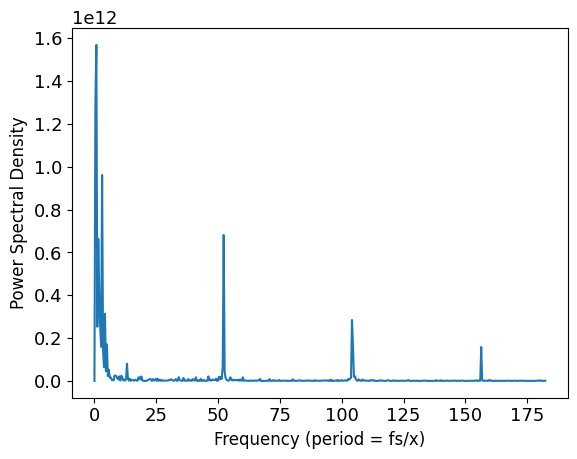

In [10]:
from scipy.signal import periodogram

italy = agg['it.m']['sum']
numeric_values = italy.values 

freq, spectrum = periodogram(numeric_values, fs=365)
plt.plot(freq,spectrum)
plt.xlabel('Frequency (period = fs/x)')
plt.ylabel('Power Spectral Density')
plt.show()

# There are some weekly patterns -> peak at fs/52 = 7: weekly peak

Calculate the nb of times each topic has been consulted (over the whole time period):

In [11]:
def sum_topics(datadict, country):
    topics_country = datadict[country]['topics']
    
    sums_list = []
    
    for i, topic in enumerate(topics):
        topic_data = topics_country[topics[i]]['sum']
        topic_values = topic_data.values
        total_sum = np.sum(topic_values)
        sums_list.append((topics[i], total_sum))
        total_sum = 0
        
    return sums_list

Plots of the 'popularity' of each topic for specific countries:

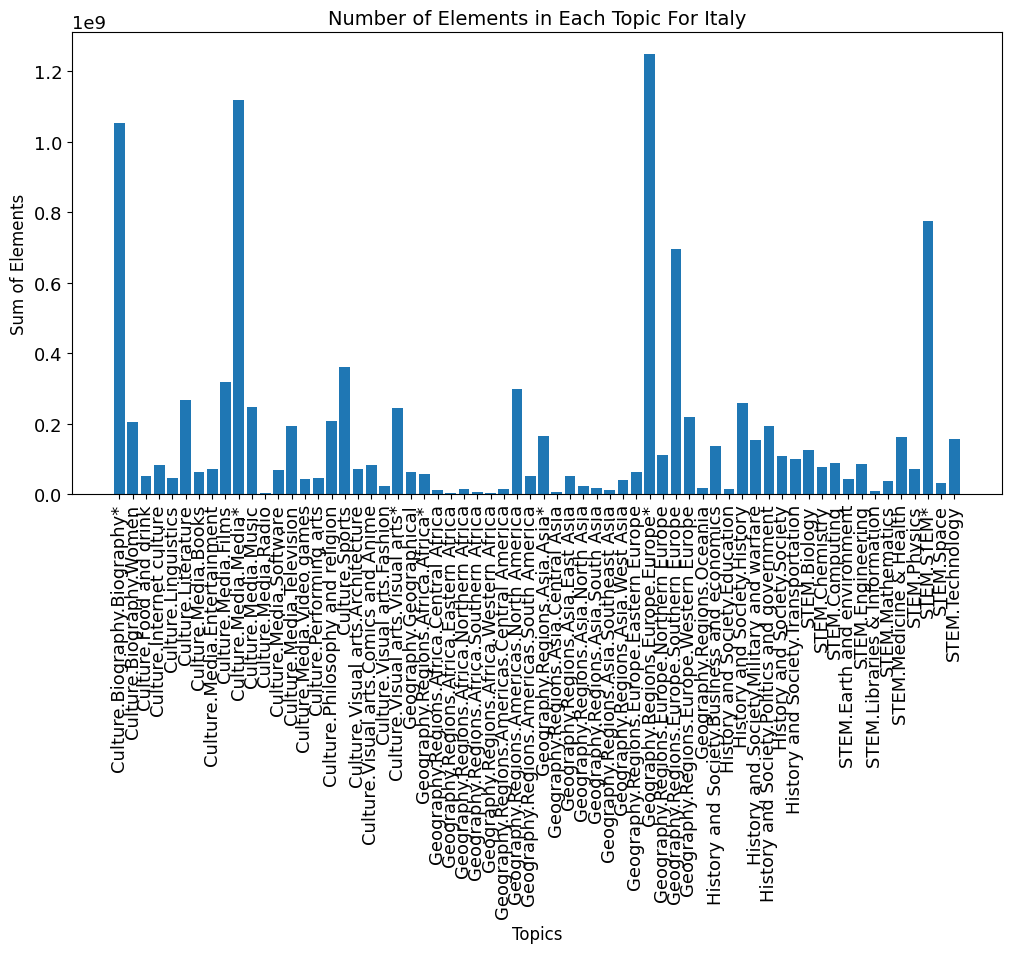

In [12]:
sums_list = sum_topics(agg, 'it')

topics = [item[0] for item in sums_list]
sums = [item[1] for item in sums_list]

plt.figure(figsize=(12, 6))
plt.bar(topics, sums)
plt.xticks(rotation=90)
plt.xlabel('Topics')
plt.ylabel('Sum of Elements')
plt.title('Number of Elements in Each Topic For Italy')
plt.show()

[('Culture.Biography.Biography*', 318124933), ('Culture.Biography.Women', 63147129), ('Culture.Food and drink', 33752051), ('Culture.Internet culture', 24007855), ('Culture.Linguistics', 24851190), ('Culture.Literature', 56971184), ('Culture.Media.Books', 13818274), ('Culture.Media.Entertainment', 15492228), ('Culture.Media.Films', 40295092), ('Culture.Media.Media*', 243792516), ('Culture.Media.Music', 80791377), ('Culture.Media.Radio', 2567981), ('Culture.Media.Software', 25871800), ('Culture.Media.Television', 31357840), ('Culture.Media.Video games', 8894416), ('Culture.Performing arts', 10580166), ('Culture.Philosophy and religion', 76361784), ('Culture.Sports', 105410096), ('Culture.Visual arts.Architecture', 23741130), ('Culture.Visual arts.Comics and Anime', 8743869), ('Culture.Visual arts.Fashion', 8665443), ('Culture.Visual arts.Visual arts*', 62554491), ('Geography.Geographical', 38087741), ('Geography.Regions.Africa.Africa*', 28498480), ('Geography.Regions.Africa.Central Afri

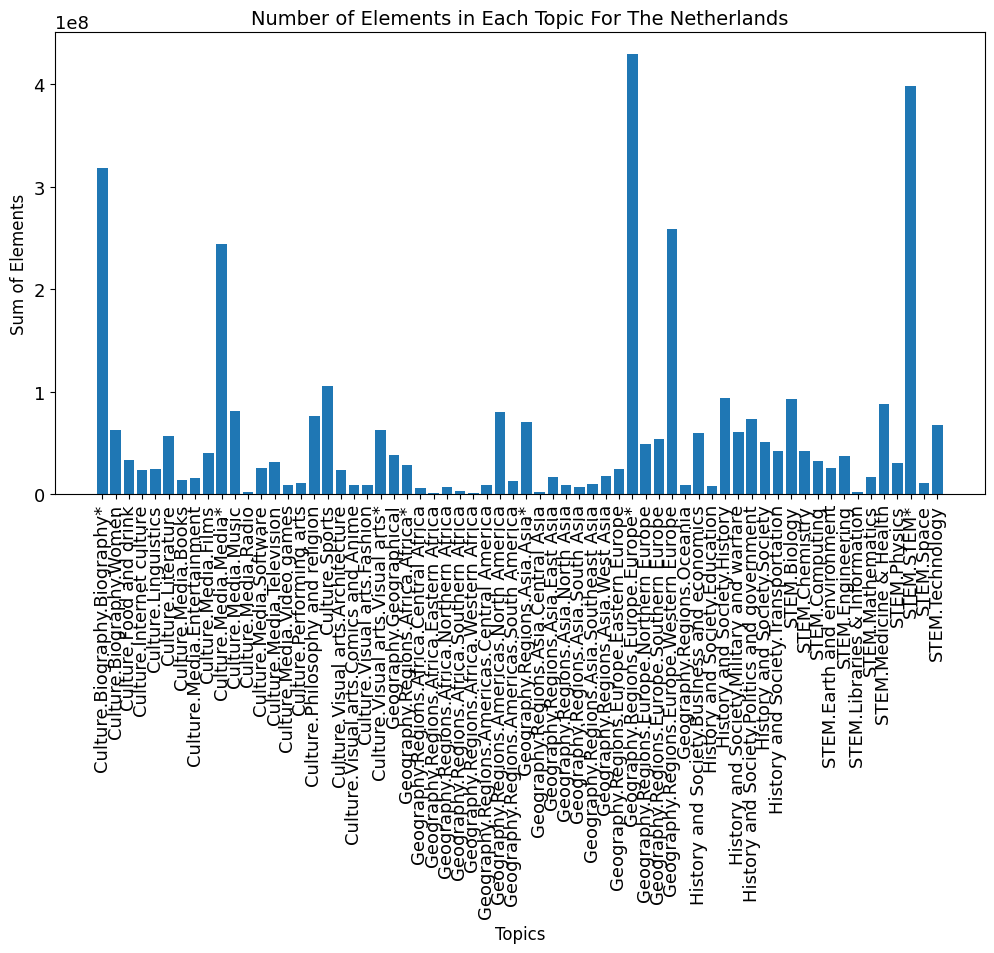

In [13]:
sums_list = sum_topics(agg, 'nl')

print(sums_list)

topics = [item[0] for item in sums_list]
sums = [item[1] for item in sums_list]

plt.figure(figsize=(12, 6))
plt.bar(topics, sums)
plt.xticks(rotation=90)
plt.xlabel('Topics')
plt.ylabel('Sum of Elements')
plt.title('Number of Elements in Each Topic For The Netherlands')
plt.show()